In [1]:
'''
The following notebook presents a hybrid news recommendation system that combines BERT-based content analysis with user interaction history. 
It calculates two similarity scores:

First, content similarity is determined by averaging the embeddings of items a user has interacted with and computing their cosine similarity 
against all item embeddings using the DistilBERT model. Second, collaborative filtering scores are derived by averaging the user vectors of the 
interacted items and measuring their cosine similarity with all item-user vectors. The final recommendations are generated by equally weighting 
both scores, enhancing the model's explainability and allowing for future optimizations or the integration of additional scoring methods.

To limit the otherwise massive memory requirements, the reduced similarity matrix focuses on computing and storing only the top K most similar 
items for each item, rather than all pairwise similarities. This targeted approach significantly reduces the size of the resulting matrix,
making it feasible to handle larger datasets while retaining the most relevant information for recommendations. By focusing only on the most
meaningful relationships, this method also reduces computational overhead, especially when combined with further processing techniques.
'''
# Import necessary libraries
import numpy as np
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertModel
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import re  # For text cleaning
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
import ast

# Check if GPU is available and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [2]:

# Load the data
news_path = 'news.tsv'
behaviors_path = 'behaviors.tsv'

# Define column names
news_columns = ['news_id', 'category', 'subcategory', 'title', 'abstract',
                'url', 'title_entities', 'abstract_entities']
behaviors_columns = ['impression_id', 'user_id', 'time', 'history', 'impressions']

# Read the TSV files
news = pd.read_csv(news_path, sep='	', names=news_columns)
behaviors = pd.read_csv(behaviors_path, sep='	', names=behaviors_columns)


In [3]:

# Fill missing values in news data
news.fillna({
    'category': 'unknown',
    'subcategory': 'general',
    'title': 'Missing Title',
    'abstract': 'Missing Abstract'
}, inplace=True)

# Remove duplicates in news data
news.drop_duplicates(subset=['title', 'abstract'], inplace=True)

# Remove behaviors with missing history or impressions
behaviors.dropna(subset=['history', 'impressions'], inplace=True)

# Remove duplicate impressions in behaviors data
behaviors.drop_duplicates(subset=['impression_id'], inplace=True)


In [4]:

# Text cleaning functions
def clean_text(text):
    """Clean text by removing special characters, numbers, and converting to lowercase."""
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)    # Remove numbers
    return text.lower()

def remove_stopwords_and_lemmatize(text):
    """Remove stopwords and perform basic lemmatization."""
    stopwords = set([
        'the', 'and', 'is', 'in', 'to', 'of', 'a', 'an', 'on', 'for', 'with', 'as', 'by', 'at', 'from', 'this',
        'that', 'it', 'or', 'but', 'not', 'be', 'are', 'was', 'were', 'can', 'will', 'would', 'should', 'has', 'have',
        'had', 'do', 'does', 'did', 'which', 'if', 'then', 'than', 'so', 'such', 'there', 'about', 'into', 'over', 'after'
    ])
    words = text.split()
    # Basic lemmatization (remove plural "s")
    lemmatized = [word[:-1] if word.endswith('s') else word for word in words]
    return ' '.join(word for word in lemmatized if word not in stopwords)

def preprocess_text(text):
    """Full preprocessing pipeline: clean text, remove stopwords, and lemmatize."""
    cleaned_text = clean_text(text)
    return remove_stopwords_and_lemmatize(cleaned_text)


In [5]:

# Apply text cleaning to Title and Abstract
print("Preprocessing text data...")
news['clean_title'] = news['title'].apply(preprocess_text)
news['clean_abstract'] = news['abstract'].apply(preprocess_text)

# Combine the cleaned title and abstract
news['combined_text'] = news['clean_title'] + ' ' + news['clean_abstract']

# Verify that there are no NaN values in 'combined_text'
assert news['combined_text'].isna().sum() == 0, "There are NaN values in 'combined_text'"


Preprocessing text data...


In [6]:

# Initialize DistilBERT tokenizer and model
print("Loading DistilBERT model...")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)


Loading DistilBERT model...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\nicla\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\nicla\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

C:\Users\nicla\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [7]:

# Function to get BERT embeddings for text
def get_bert_embedding(text):
    # Ensure the input is a string
    if not isinstance(text, str):
        text = ""
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    ).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the [CLS] token representation as the embedding
    return outputs.last_hidden_state[:, 0, :]

# Generate embeddings for news articles
print("Generating BERT embeddings for news articles...")
news_embeddings_list = [get_bert_embedding(text) for text in news['combined_text'].tolist()]
news_embeddings = torch.cat(news_embeddings_list, dim=0)  # Shape: (num_articles, embedding_dim)

# Normalize embeddings
print("Normalizing embeddings...")
news_embeddings = F.normalize(news_embeddings, p=2, dim=1)  # L2 normalization


Generating BERT embeddings for news articles...
Normalizing embeddings...


In [8]:
# Collaborative filtering component: create user-item interaction matrix
print("Creating user-item interaction matrix...")
user_ids = behaviors['user_id'].unique()
news_ids = news['news_id'].unique()

# Create mappings from IDs to indices
user_id_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
news_id_to_index = {news_id: idx for idx, news_id in enumerate(news_ids)}

# Initialize empty lists for COO format
row_indices = []
col_indices = []
data = []

for _, row in behaviors.iterrows():
    user_id = row['user_id']
    impressions = row['impressions'].split()
    for impression in impressions:
        if '-' in impression:
            news_id, clicked = impression.split('-')
            if news_id in news_id_to_index and clicked == '1':  # Mark as clicked
                user_idx = user_id_to_index[user_id]
                news_idx = news_id_to_index[news_id]
                row_indices.append(user_idx)
                col_indices.append(news_idx)
                data.append(1)

num_users = len(user_ids)
num_items = len(news_ids)

# Create sparse interaction matrix in COO format
indices = torch.LongTensor([row_indices, col_indices])  # Shape: [2, num_interactions]
values = torch.FloatTensor(data)
user_item_matrix = torch.sparse_coo_tensor(indices, values, (num_users, num_items)).to(device)



Creating user-item interaction matrix...


In [9]:
# Hybrid Recommendation: Combining content similarity and user interaction
alpha = 0.5  # Weight for combining collaborative and content-based recommendations
K = 10       # Number of recommendations per user

print("Generating hybrid recommendations with scores...")
hybrid_recommendations = {}

num_users = user_item_matrix.shape[0]
num_items = news_embeddings.shape[0]
embedding_dim = news_embeddings.shape[1]

# Prepare item factors from user-item interactions
item_user_matrix = user_item_matrix.transpose(0, 1).to_dense()  # Shape: (num_items, num_users)

# Normalize item-user matrix
item_user_norms = item_user_matrix.norm(p=2, dim=1, keepdim=True)
item_user_matrix = item_user_matrix / (item_user_norms + 1e-8)  # Avoid division by zero

# Move item_user_matrix to GPU if not already
item_user_matrix = item_user_matrix.to(device)

for user_idx in range(num_users):
    # Get the user interaction vector
    user_interactions = user_item_matrix[user_idx].to_dense()  # Shape: (num_items,)
    interacted_items = user_interactions.nonzero(as_tuple=False).squeeze(1)

    # Skip users with no interactions
    if interacted_items.numel() == 0:
        continue

    # Compute content-based scores
    # Average the embeddings of items the user has interacted with
    user_content_embedding = news_embeddings[interacted_items].mean(dim=0, keepdim=True)  # Shape: (1, embedding_dim)
    user_content_embedding = F.normalize(user_content_embedding, p=2, dim=1)

    # Compute content scores (cosine similarity)
    content_scores = torch.mm(news_embeddings, user_content_embedding.t()).squeeze(1)  # Shape: (num_items,)

    # Compute collaborative filtering scores
    # Average the item-user vectors of items the user has interacted with
    user_collaborative_vector = item_user_matrix[interacted_items].mean(dim=0, keepdim=True)  # Shape: (1, num_users)
    user_collaborative_vector = F.normalize(user_collaborative_vector, p=2, dim=1)

    # Compute collaborative scores (cosine similarity)
    collaborative_scores = torch.mm(item_user_matrix, user_collaborative_vector.t()).squeeze(1)  # Shape: (num_items,)

    # Hybrid score: weighted combination
    hybrid_scores = alpha * content_scores + (1 - alpha) * collaborative_scores

    # Exclude already interacted items from recommendations
    hybrid_scores[interacted_items] = -float('Inf')  # Set to negative infinity to avoid recommending

    # Get top K recommendations for this user
    hybrid_scores_cpu = hybrid_scores.cpu()
    top_scores, top_indices = torch.topk(hybrid_scores_cpu, K)
    recommended_news_ids = [news_ids[idx] for idx in top_indices.numpy()]
    recommended_scores = top_scores.numpy()
    recommended_content_scores = content_scores.cpu()[top_indices].numpy()
    recommended_collab_scores = collaborative_scores.cpu()[top_indices].numpy()

    # Store the recommendations and scores
    user_id = user_ids[user_idx]
    hybrid_recommendations[user_id] = {
        'news_ids': recommended_news_ids,
        'hybrid_scores': recommended_scores,
        'content_scores': recommended_content_scores,
        'collaborative_scores': recommended_collab_scores
    }

print("Hybrid recommendation generation with scores completed.")


Generating hybrid recommendations with scores...
Hybrid recommendation generation with scores completed.


In [10]:
# Create a DataFrame from the hybrid_recommendations dictionary
recommendations_list = []
for user_id, rec_data in hybrid_recommendations.items():
    for idx in range(len(rec_data['news_ids'])):
        recommendations_list.append({
            'user_id': user_id,
            'news_id': rec_data['news_ids'][idx],
            'hybrid_score': rec_data['hybrid_scores'][idx],
            'content_score': rec_data['content_scores'][idx],
            'collaborative_score': rec_data['collaborative_scores'][idx]
        })

recommendations_df = pd.DataFrame(recommendations_list)

# Save the DataFrame to a CSV file
output_file = 'hybrid_recommendations_with_scores.csv'
recommendations_df.to_csv(output_file, index=False)

print(f"Hybrid recommendations with scores have been saved to {output_file}")


Hybrid recommendations with scores have been saved to hybrid_recommendations_with_scores.csv


In [11]:
# Move embeddings to CPU and convert to NumPy
news_embeddings_cpu = news_embeddings.cpu().numpy()

# Save the calculated embeddings
print("Saving embeddings to 'news_embeddings.npy'...")
np.save('news_embeddings.npy', news_embeddings_cpu)
print("Embeddings saved successfully.")


Saving embeddings to 'news_embeddings.npy'...
Embeddings saved successfully.


In [12]:
# Load necessary libraries
import pandas as pd

# Load the news DataFrame
news_path = 'news.tsv'
news_columns = ['news_id', 'category', 'subcategory', 'title', 'abstract',
                'url', 'title_entities', 'abstract_entities']
news = pd.read_csv(news_path, sep='\t', names=news_columns)

# Load the saved recommendations with scores
recommendations_df = pd.read_csv('hybrid_recommendations_with_scores.csv')

# Select 5 sample users
sample_users = recommendations_df['user_id'].unique()[:5]

# For each sample user, print the top 10 recommendations with scores, title, abstract, and explanations
for user_id in sample_users:
    user_recs = recommendations_df[recommendations_df['user_id'] == user_id].head(10)
    print("=" * 80)
    print(f"User ID: {user_id}")
    print("Top 10 Recommendations:")
    print("-" * 80)
    for idx, row in user_recs.iterrows():
        news_id = row['news_id']
        hybrid_score = row['hybrid_score']
        content_score = row['content_score']
        collaborative_score = row['collaborative_score']
        # Determine the reason for recommendation
        if content_score > collaborative_score:
            reason = 'Based on similar content you liked.'
        else:
            reason = 'Popular among users with similar interests.'
        # Find the news article in the news DataFrame
        news_article = news[news['news_id'] == news_id]
        if not news_article.empty:
            title = news_article['title'].values[0]
            abstract = news_article['abstract'].values[0]
            print(f"News ID: {news_id}")
            print(f"Hybrid Score: {hybrid_score:.4f}")
            print(f"Content Score: {content_score:.4f}")
            print(f"Collaborative Score: {collaborative_score:.4f}")
            print(f"Reason: {reason}")
            print(f"Title: {title}")
            print(f"Abstract: {abstract}")
            print("-" * 80)
        else:
            print(f"News ID: {news_id} not found in news DataFrame.")
            print("-" * 80)


User ID: U13740
Top 10 Recommendations:
--------------------------------------------------------------------------------
News ID: N63832
Hybrid Score: 0.5501
Content Score: 0.9042
Collaborative Score: 0.1960
Reason: Based on similar content you liked.
Title: Celtics' Gordon Hayward to have surgery on fractured hand
Abstract: Boston Celtics forward Gordon Hayward will have surgery on his left hand Monday, according to Adrian Wojnarowski.
--------------------------------------------------------------------------------
News ID: N16732
Hybrid Score: 0.5431
Content Score: 0.9110
Collaborative Score: 0.1753
Reason: Based on similar content you liked.
Title: John Brannen will 're-evaluate' status of Cincinnati basketball star Jarron Cumberland
Abstract: Cincinnati basketball star Jarron Cumberland will not play Thursday against Alabama A&M for an undisclosed reason.
--------------------------------------------------------------------------------
News ID: N13077
Hybrid Score: 0.5392
Content Sc

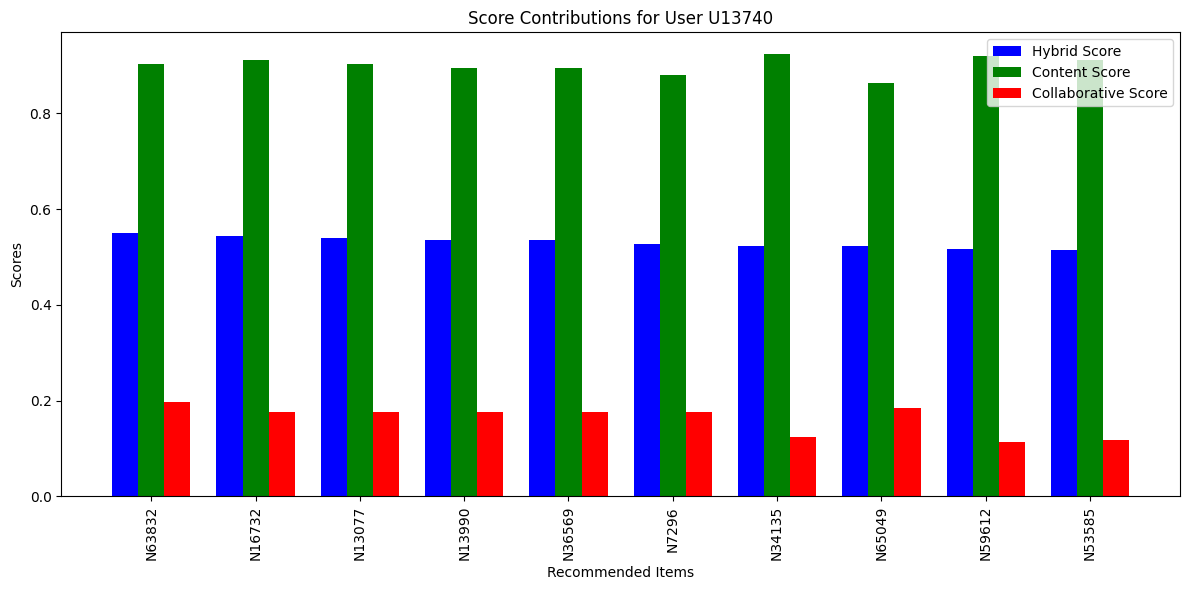

In [13]:
import matplotlib.pyplot as plt

# Choose a sample user
user_id = sample_users[0]
user_recs = recommendations_df[recommendations_df['user_id'] == user_id].head(10)

# Extract scores
news_ids = user_recs['news_id'].tolist()
hybrid_scores = user_recs['hybrid_score'].tolist()
content_scores = user_recs['content_score'].tolist()
collaborative_scores = user_recs['collaborative_score'].tolist()

# Plot the scores
x = np.arange(len(news_ids))
width = 0.25  # Width of the bars

plt.figure(figsize=(12, 6))
plt.bar(x - width, hybrid_scores, width=width, label='Hybrid Score', color='blue')
plt.bar(x, content_scores, width=width, label='Content Score', color='green')
plt.bar(x + width, collaborative_scores, width=width, label='Collaborative Score', color='red')

plt.xlabel('Recommended Items')
plt.ylabel('Scores')
plt.title(f'Score Contributions for User {user_id}')
plt.xticks(x, news_ids, rotation='vertical')
plt.legend()
plt.tight_layout()
plt.show()


Performing t-SNE dimensionality reduction...


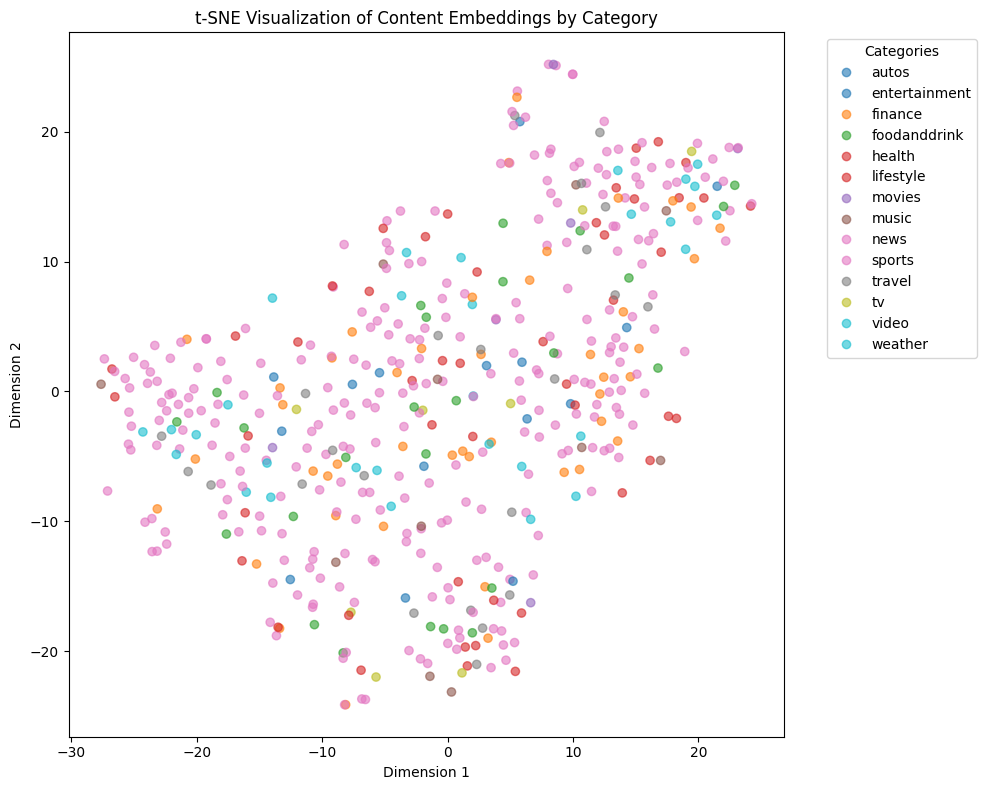

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Sample a subset of embeddings to visualize
subset_size = 500  # Adjust as needed
subset_indices = np.random.choice(news_embeddings.shape[0], size=subset_size, replace=False)
subset_embeddings = news_embeddings[subset_indices].cpu().numpy()

# Reduce dimensions with t-SNE
print("Performing t-SNE dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(subset_embeddings)

# Get the categories for the subset
subset_news = news.iloc[subset_indices]
categories = subset_news['category'].tolist()

# Encode categories as numbers
le = LabelEncoder()
category_ids = le.fit_transform(categories)

# Plot with categories
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=category_ids, cmap='tab10', alpha=0.6)
plt.title('t-SNE Visualization of Content Embeddings by Category')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Generate a legend with correct mapping
handles, _ = scatter.legend_elements()
labels = le.inverse_transform(np.unique(category_ids))
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', title="Categories")

plt.tight_layout()
plt.show()


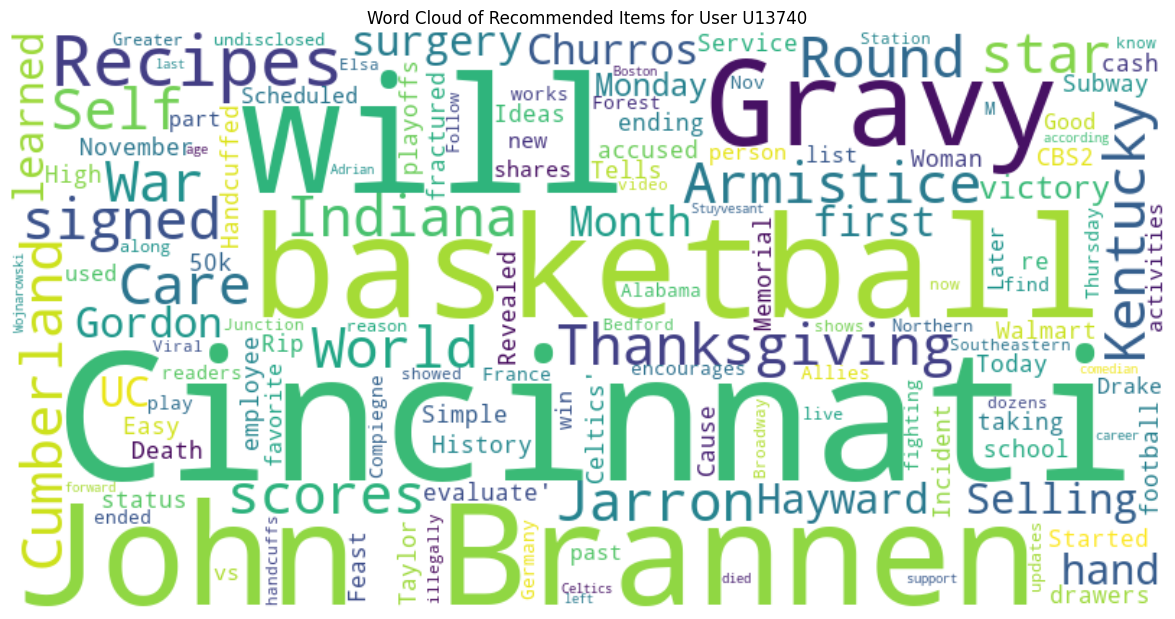

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Choose a sample user
user_id = sample_users[0]
user_recs = recommendations_df[recommendations_df['user_id'] == user_id].head(10)
recommended_news_ids = user_recs['news_id'].tolist()

# Get the text data
recommended_news = news[news['news_id'].isin(recommended_news_ids)]

# Ensure all titles and abstracts are strings
titles = recommended_news['title'].fillna("").astype(str).tolist()
abstracts = recommended_news['abstract'].fillna("").astype(str).tolist()

# Concatenate the text data
text_data = ' '.join(titles + abstracts)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display the word cloud
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Word Cloud of Recommended Items for User {user_id}')
plt.show()

